# Plot Intro Case

Interesting cases: al122024 (Kirk), sh022025 (Bheki), sh132025

Wind profile evolution with all the marks (Rmax/Vmax, f, Rxx, B, Uc, Rossby,  R+/R0) and insets with the evolution of each of these parameters on the side. For now color in shades of black to brown for before LMI, and shades of red-to-purple for after.

Eventually add Argo profiles, MSLP, etc ?

DONE: Add best-track values (ask Alexis first, Kirk is the plot from the RSE Sentinel-1 review and Rmax_BTK is quite accurate). Note that B is too complicated to fit from BTK (and thus Uc and R+ cannot be properly estimated).

NB: The results for the wind radii Rxx (SAR vs BTK) seem inconsistent with those from Nils, but he computed his SAR wind radii in 2D. So everything is in order.

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Paths & Params
PRMS = {
    'ibt_vars2keep':    ['usa_lon', 'usa_lat', 'usa_pres', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':    ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
}

PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/03_PLOT_INTRO_CASE/',
    'ibt_pth': '/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc',
}

### Open data
# SAR
dsg        = xr.open_dataset(PTHS['sar_pth'])

# IBTrACS
ds_ibt_all = xr.open_dataset(PTHS['ibt_pth'])
# Select variables
ds_ibt                        = ds_ibt_all[PRMS['ibt_vars2keep']]
ds_ibt[PRMS['ibt_info2keep']] = ds_ibt_all[PRMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings
# Select dates
start_date                    = np.datetime64('2009-01-01')
fsi                           = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt                        = ds_ibt.isel(storm=slice(fsi, None))
# Convert to m/s and m units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
for radius in ['usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw']:
    ds_ibt[radius] *= 1852
# Add mean radii
# Non-zero average!!
ds_ibt['mean_r34'] = xr.where(ds_ibt.usa_r34 != 0, ds_ibt.usa_r34, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r50'] = xr.where(ds_ibt.usa_r50 != 0, ds_ibt.usa_r50, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r64'] = xr.where(ds_ibt.usa_r64 != 0, ds_ibt.usa_r64, np.nan).mean(dim='quadrant', skipna=True)
# Intensification and growing rates in IBTrACS
ds_ibt['vmx_smth']       = ds_ibt.usa_wind.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['r34_smth']       = ds_ibt.mean_r34.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['vmx_dot_smth']   = ds_ibt.vmx_smth.differentiate(coord='date_time') / 3 # m/s/hr
ds_ibt['r34_dot_smth']   = ds_ibt.r34_smth.differentiate(coord='date_time') / 3 # km/hr
# ==> Add LMI values
new                      = ds_ibt.fillna(-9999)
idx_lmi                  = new.vmx_smth.argmax(dim='date_time')
# LMI
ds_ibt['lmi']            = ds_ibt.usa_wind[:, idx_lmi]
ds_ibt['t_lmi']          = ds_ibt.time[:, idx_lmi]
# time since LMI
dt                       = (ds_ibt.time - ds_ibt.t_lmi)
dt_scds                  = dt.dt.days * 24 * 3600 + dt.dt.seconds # Nb of days + Nb of seconds (>= 0 and less than 1 day) for each element
ds_ibt['t_since_lmi']    = dt_scds # in seconds

In [3]:
### Choose ID
atcf_id = 'al122024'

In [4]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/2121 [00:00<?, ?it/s]

In [5]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

718


In [6]:
# ### Colormap
# # Pour le segment négatif (-72 à 0)
# color_start_neg = 'black'           # Couleur à -72
# color_end_neg   = 'darkgoldenrod' # Couleur à 0 (côté négatif)

# # Pour le segment positif (0 à 72)
# color_start_pos = 'burlywood'          # Couleur à 0 (côté positif)
# color_end_pos   = 'crimson'        # Violet (couleur choisie pour l'exemple : 'blueviolet')

# # --- 2. Créer les deux segments de colormap ---
# # Segment pour les valeurs négatives : de noir à marron clair
# # N=128 pour avoir suffisamment de points d'échantillonnage pour un dégradé lisse
# cmap_neg_segment = mcolors.LinearSegmentedColormap.from_list(
#     'neg_part_cmap', [color_start_neg, color_end_neg], N=128
# )

# # Segment pour les valeurs positives : de rouge à violet
# cmap_pos_segment = mcolors.LinearSegmentedColormap.from_list(
#     'pos_part_cmap', [color_start_pos, color_end_pos], N=128
# )

# # --- 3. Combiner les deux segments en une seule colormap ---
# # Nous échantillonnons chaque segment et les empilons.
# # Le nombre total de couleurs N=256 est standard pour une bonne résolution.
# combined_colors = np.vstack((
#     cmap_neg_segment(np.linspace(0, 1, 128)), # Échantillonne le segment négatif
#     cmap_pos_segment(np.linspace(0, 1, 128))  # Échantillonne le segment positif
# ))

# # Crée la colormap finale à partir des couleurs combinées
# cmap = mcolors.LinearSegmentedColormap.from_list(
#     'black_brown_red_violet_continuous', combined_colors, N=256
# )

# norm = mcolors.TwoSlopeNorm(vmin=-72, vcenter=0, vmax=72)
# cmap

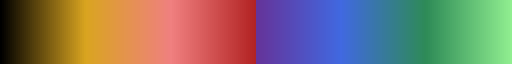

In [7]:
### Colormap

# Définition des limites de la plage totale
vmin = -72
vmax = 72

# Segment 1: -72 à -48
color_neg_72 = 'black'
color_neg_48 = 'goldenrod' 

# Segment 2: -48 à -24
color_neg_24 = 'lightcoral' 

# Segment 3: -24 à 0
color_zero_neg_side = 'firebrick' 

# Segment 4: 0 à 24
color_zero_pos_side = 'rebeccapurple' 

# Segment 5: 24 à 48
color_pos_24 = 'royalblue'

# Segment 6: 48 à 72
color_pos_48 = 'seagreen'
color_pos_72 = 'lightgreen' 

# Fonction utilitaire pour normaliser une valeur
def normalize_value(val, vmin, vmax):
    return (val - vmin) / (vmax - vmin)

colors_and_positions = [
    # Segment 1: -72 à -48 (de noir à rouge foncé)
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),

    # Segment 2: -48 à -24 (de rouge foncé à orange)
    # Note: color_neg_48 est répété pour assurer la continuité
    (normalize_value(-48, vmin, vmax), color_neg_48), # Point de départ du segment 2
    (normalize_value(-24, vmin, vmax), color_neg_24),

    # Segment 3: -24 à 0 (d'orange à gris clair)
    (normalize_value(-24, vmin, vmax), color_neg_24), # Point de départ du segment 3
    (normalize_value(0, vmin, vmax), color_zero_neg_side),

    # Segment 4: 0 à 24 (de gris clair à bleu clair)
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Point de départ du segment 4
    (normalize_value(24, vmin, vmax), color_pos_24),

    # Segment 5: 24 à 48 (de bleu clair à vert foncé)
    (normalize_value(24, vmin, vmax), color_pos_24), # Point de départ du segment 5
    (normalize_value(48, vmin, vmax), color_pos_48),

    # Segment 6: 48 à 72 (de vert foncé à violet à jaune vif)
    (normalize_value(48, vmin, vmax), color_pos_48), # Point de départ du segment 6
    (normalize_value(vmax, vmin, vmax), color_pos_72),
]

cmap_points = [
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),
    (normalize_value(-24, vmin, vmax), color_neg_24),
    (normalize_value(0, vmin, vmax), color_zero_neg_side), # Couleur à 0 pour les négatifs
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Couleur à 0 pour les positifs (pour une transition nette si désirée)
    (normalize_value(24, vmin, vmax), color_pos_24),
    (normalize_value(48, vmin, vmax), color_pos_48),
    (normalize_value(vmax, vmin, vmax), color_pos_72)
]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_multi_segment_cmap", cmap_points)

# Pour la normalisation, TwoSlopeNorm est toujours appropriée si 0 est votre centre de pivot
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

cmap

In [8]:
### Select case
# SAR
ds  = d.where(d.id == atcf_id, drop=True)
# BTK
dsi = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id.upper(), drop=True).isel(storm=0)
dsi = dsi.where(((dsi.t_since_lmi / 3600) >= -72) & ((dsi.t_since_lmi / 3600) <= 72), drop=True)

In [9]:
# A23 and other parameters
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def M(f, r, V):
    return r * V + 0.5 * f * (r ** 2)

def Rmax_from_M(fcor, Mmax, Vmax):
    return (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)

def correct_vmx_ibt(vmx_ibt):
    return 0.6967 * vmx_ibt + 6.1992

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

# Bounds for fitting
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Basics
dsi['vmx_reg'] = correct_vmx_ibt(dsi['usa_wind'])
dsi['fcr']     = coriolis(dsi['usa_lat'])

# Rmax A23
# Compute the momentum ratios
Mm_M34 = 0.531 * np.exp(
    -0.00214 * (dsi['vmx_reg'] - 17.5)
    -0.00314 * (dsi['vmx_reg'] - 17.5) * 0.5 * dsi['fcr'] * dsi['mean_r34']
)
Mm_M50 = 0.626 * np.exp(
     0.00282 * (dsi['vmx_reg'] - 25.7)
    -0.00724 * (dsi['vmx_reg'] - 25.7) * 0.5 * dsi['fcr'] * dsi['mean_r50']
)
Mm_M64 = 0.612 * np.exp(
     0.00946 * (dsi['vmx_reg'] - 32.9)
    -0.01183 * (dsi['vmx_reg'] - 32.9) * 0.5 * dsi['fcr'] * dsi['mean_r64']
)
# Compute Mmax
Mm_with_r34 = Mm_M34 * M(dsi['fcr'], dsi['mean_r34'], 17.5)
Mm_with_r50 = Mm_M50 * M(dsi['fcr'], dsi['mean_r50'], 25.7)
Mm_with_r64 = Mm_M64 * M(dsi['fcr'], dsi['mean_r64'], 32.9)
# Compute Rmax_CK22A23
Rm_with_r34 = Rmax_from_M(dsi['fcr'], Mm_with_r34, dsi['vmx_reg'])
Rm_with_r50 = Rmax_from_M(dsi['fcr'], Mm_with_r50, dsi['vmx_reg'])
Rm_with_r64 = Rmax_from_M(dsi['fcr'], Mm_with_r64, dsi['vmx_reg'])
# Assign to your dataset
dsi['new_rmx'] = Rm_with_r34.copy(deep=True)
dsi['new_rmx'][Rm_with_r50.notnull()] = Rm_with_r50.copy(deep=True)[Rm_with_r50.notnull()]
dsi['new_rmx'][Rm_with_r64.notnull()] = Rm_with_r64.copy(deep=True)[Rm_with_r64.notnull()]

# Others
dsi['rsb']     = dsi['usa_wind'] / (abs(dsi['fcr']) * dsi['usa_rmw'])
dsi['r0']      = np.sqrt(2 * dsi['rsb']) * dsi['usa_rmw']
dsi['new_rsb'] = dsi['vmx_reg'] / (abs(dsi['fcr']) * dsi['new_rmx'])
dsi['new_r0']  = np.sqrt(2 * dsi['new_rsb']) * dsi['new_rmx']

In [10]:
### Add Bs, Uc, and R+

  0%|          | 0/49 [00:00<?, ?it/s]

/tmp/ipykernel_20797/905835419.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


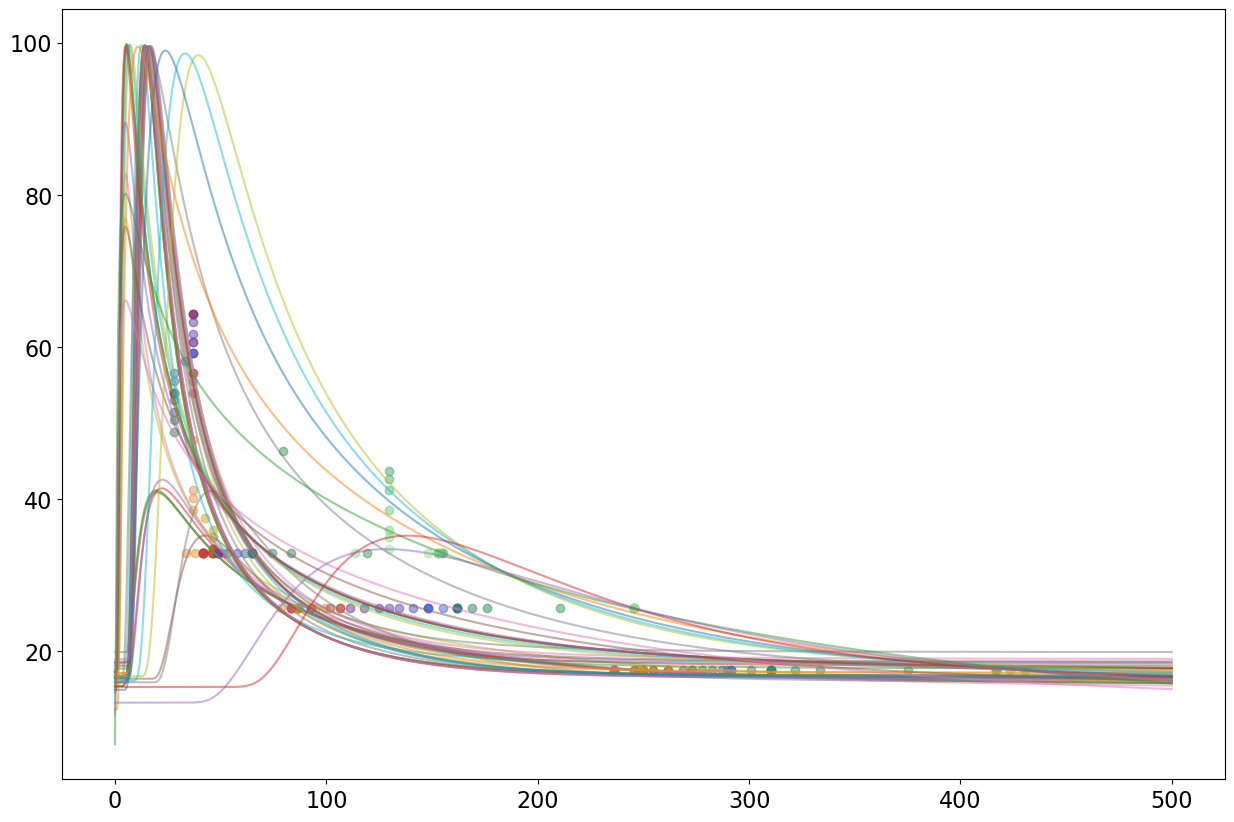

In [11]:
# Add Bs 
# Adjusts a Holland wind profile to BTK wind radii
# Only when both r34, r50 and r64 are defined to ensure minimum number of valid points
# Fitting results look bad
# NB: I tried to enforce Vmin = 10m/s (i.e average SAR ds.vmin.mean()), but this doesn't improve fittings

Bs   = []
VMNs = []
RMXs = []
VMXs = []

for d in tqdm(range(len(dsi.date_time))):
    # Concatenate wind radii
    rss = [float(dsi.isel(date_time=d)['usa_rmw']), float(dsi.isel(date_time=d)['mean_r64']), float(dsi.isel(date_time=d)['mean_r50']), float(dsi.isel(date_time=d)['mean_r34'])]
    wss = [float(dsi.isel(date_time=d)['usa_wind']), 32.9, 25.7, 17.5]

    # Fit Holland
    if np.count_nonzero(np.isnan(rss)) == 0:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, float(dsi.isel(date_time=d).usa_lat), B, Vmin, Rmax, Vmax),
            # lambda r, B, Rmax, Vmax: holland_profile(r, float(dsi.isel(date_time=d).usa_lat), B, 10, Rmax, Vmax),
            np.array(rss), 
            np.array(wss), 
            p0=[1.8, 5, 20 * 1000, 40], 
            # p0=[1.8, 20 * 1000, 40],
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        # B_hol, rmx_hol, vmx_hol = popt
        # Plot
        plt.scatter(np.array(rss) / 1000, wss, color=cmap(norm(float(dsi.isel(date_time=d).t_since_lmi / 3600))), alpha=0.5)
        plt.plot(np.linspace(0, 500000, 1001) / 1000, holland_profile(np.linspace(0, 500000, 1001), float(dsi.isel(date_time=d).usa_lat), B_hol, vmn_hol, rmx_hol, vmx_hol), alpha=0.5)
        # plt.plot(np.linspace(0, 500000, 1001) / 1000, holland_profile(np.linspace(0, 500000, 1001), float(dsi.isel(date_time=d).usa_lat), B_hol, 10, rmx_hol, vmx_hol), alpha=0.5)
    else:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        # B_hol = rmx_hol = vmx_hol = np.nan
    # Append
    Bs.append(B_hol)
    VMNs.append(vmn_hol)
    RMXs.append(rmx_hol)
    VMXs.append(vmx_hol)
    
# plt.xlim(0, 250)
dsi['Bs']     = xr.DataArray(Bs, dims='date_time')
dsi['uc']     = np.sqrt(3 * np.sqrt(2) * dsi.usa_wind ** 2 / np.sqrt(dsi.Bs * dsi.rsb))
dsi['new_uc'] = np.sqrt(3 * np.sqrt(2) * dsi.vmx_reg ** 2 / np.sqrt(dsi.Bs * dsi.new_rsb))

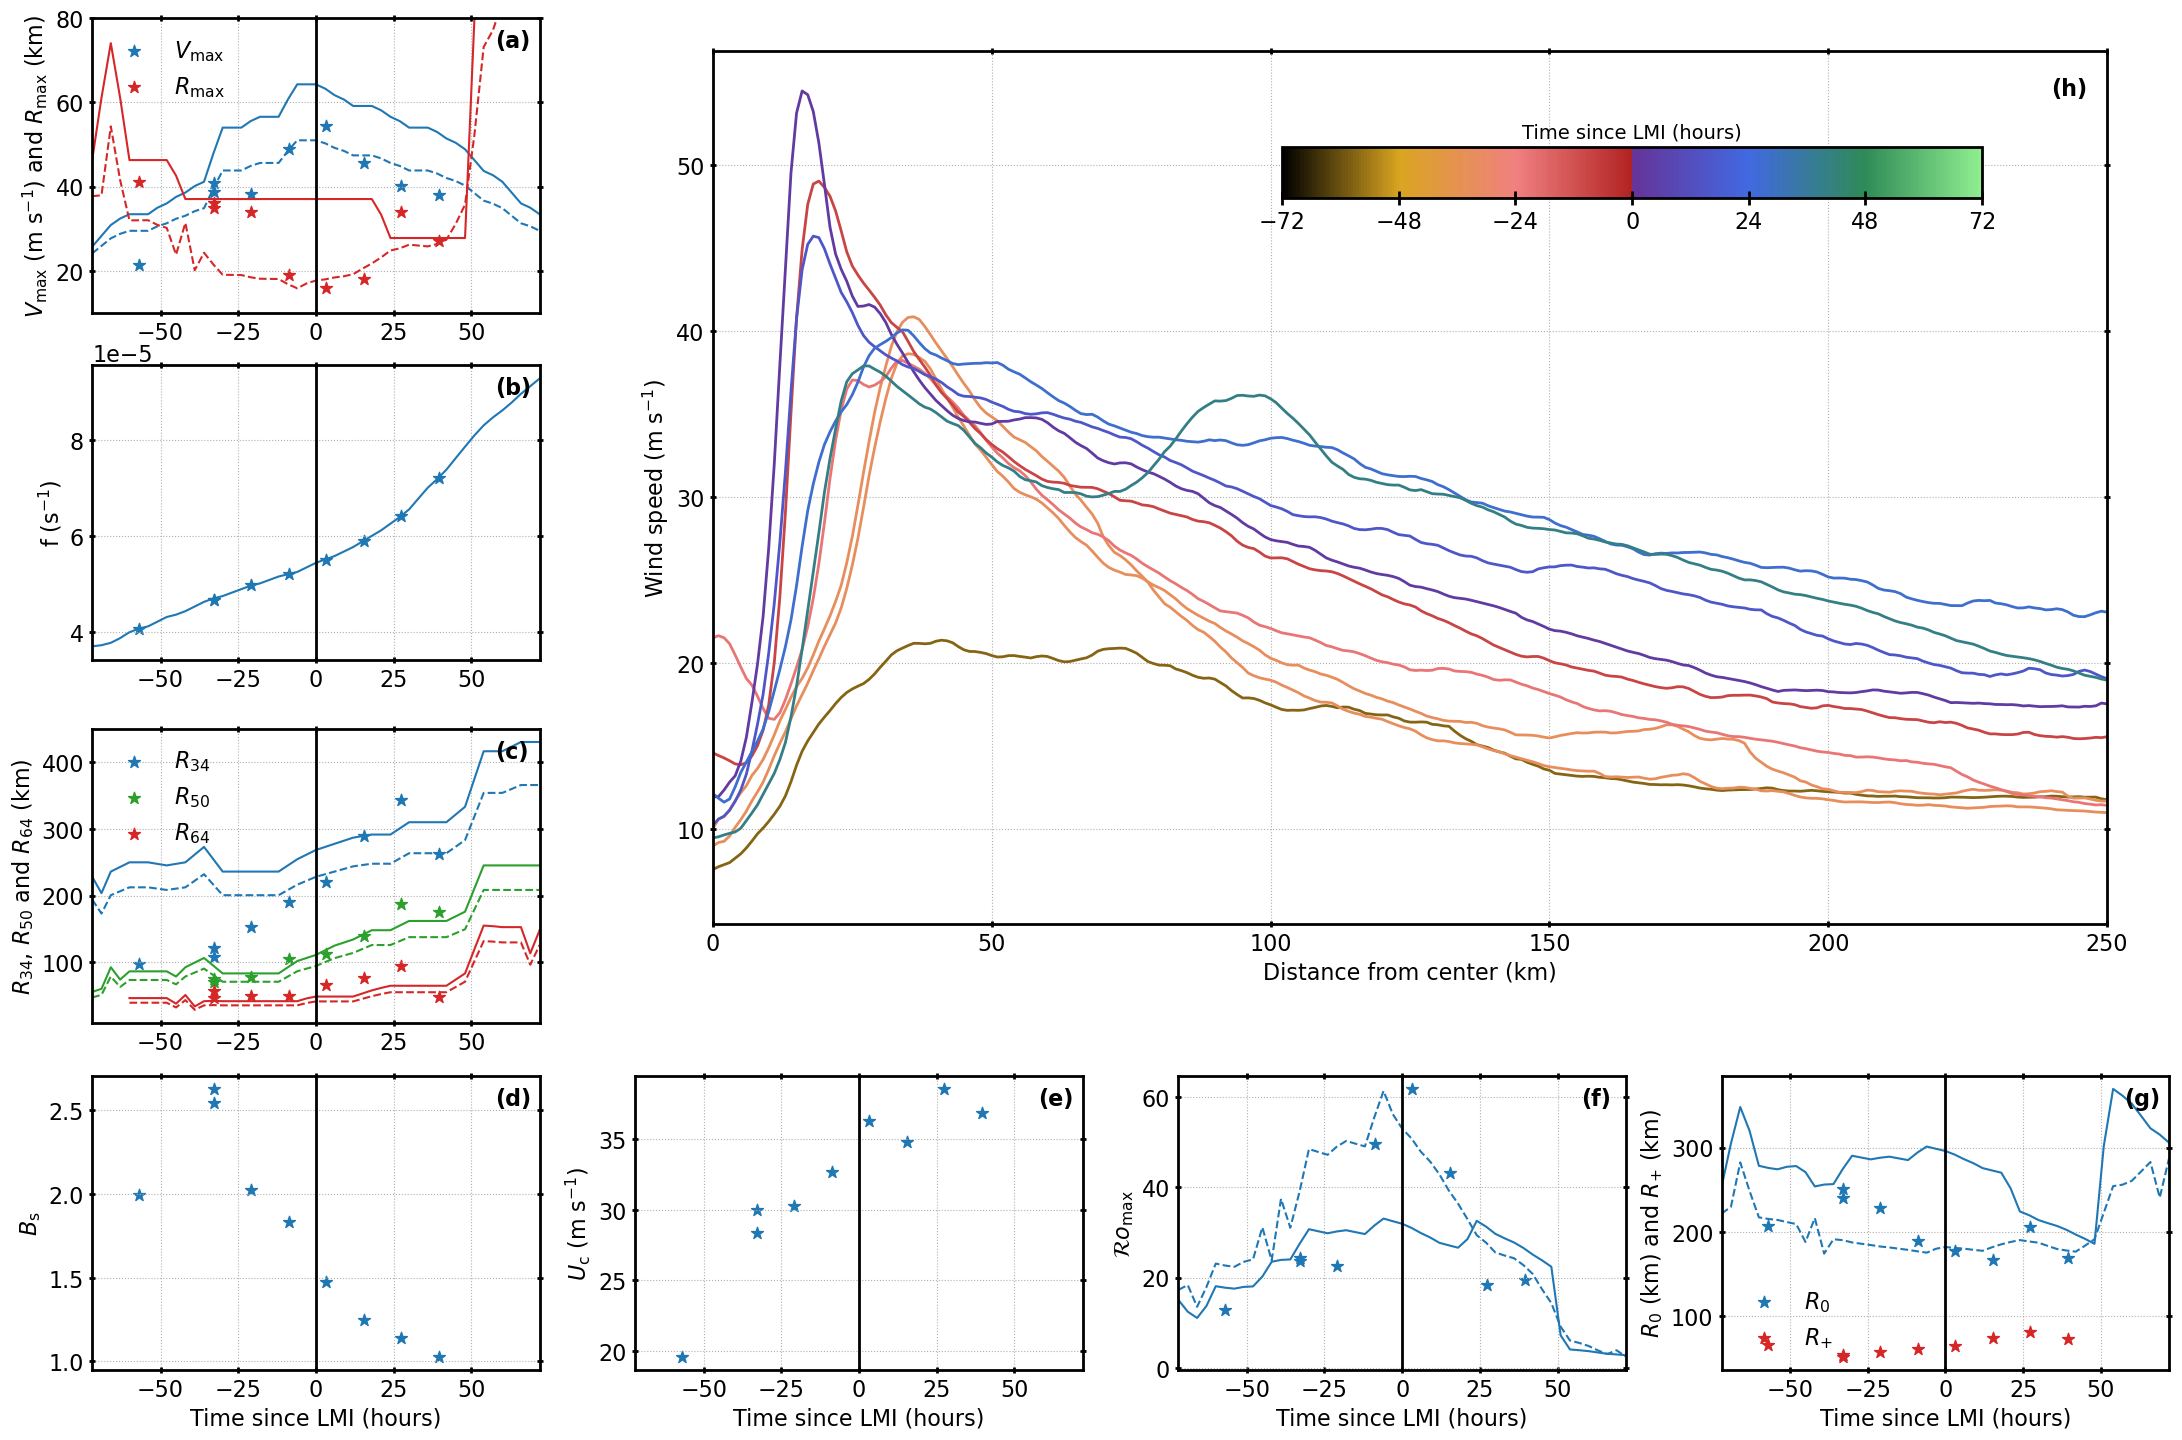

In [12]:
### POSSIBLE TO UNCOMMENT
### ALL BTK CURVES

### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 250


fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot
    ax.plot(wsm.rad / 1000, wsm, c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2)

    # Close
    dsp.close()

# Axes
ax.set_xlim(0, ax_lim)
ax.set_ylabel(r'Wind speed (m s$^{-1}$)')
ax.set_xlabel(r'Distance from center (km)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

################
### RMX/VMX  ###
################
ax = fig.add_subplot(gs[:18, :29])
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx,        marker='*', s=80, color='tab:blue', label=r'$V_{\text{max}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rmx / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{max}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_wind,                    color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.vmx_reg,                     color='tab:blue', linestyle='dashed')
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_rmw / 1000,              color='tab:red')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rmx / 1000,              color='tab:red', linestyle='dashed')
ax.set_ylim(10, 80)

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$) and $R_{\text{max}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   FCOR   ###
################
ax = fig.add_subplot(gs[21:39, :29])
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.fcor,        marker='*', s=80, color='tab:blue')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.fcr,                          color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'f (s$^{-1})$')
# ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   Rxx    ###
################
ax = fig.add_subplot(gs[43:61, :29])
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r34 / 1000, marker='*', s=80, color='tab:blue',  label=r'$R_{\text{34}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r50 / 1000, marker='*', s=80, color='tab:green', label=r'$R_{\text{50}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r64 / 1000, marker='*', s=80, color='tab:red',   label=r'$R_{\text{64}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r34 / 1000,             color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r50 / 1000,             color='tab:green')
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r64 / 1000,             color='tab:red')
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r34 / 1000,      color='tab:blue',  linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r50 / 1000,      color='tab:green', linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r64 / 1000,      color='tab:red',   linestyle='dashed',)


# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Bs    ###
################
ax = fig.add_subplot(gs[64:82, :29])
ax.text(0.9, 0.9, '(d)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.B_hol, marker='*', s=80, color='tab:blue')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,    dsi.Bs,                        color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$B_{\text{s}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Uc    ###
################
ax = fig.add_subplot(gs[64:82, 35:64])
ax.text(0.9, 0.9, '(e)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.uc, marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  Rossby  ###
################
ax = fig.add_subplot(gs[64:82, 70:99])
ax.text(0.9, 0.9, '(f)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rsby, marker='*', s=80, color='tab:blue')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.rsb,                   color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rsb,               color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  R+/R0   ###
################
ax = fig.add_subplot(gs[64:82, 105:134])
ax.text(0.9, 0.9, '(g)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r0 / 1000,  marker='*', s=80, color='tab:blue', label=r'$R_{\text{0}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rps / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{+}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.r0 / 1000,                   color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_r0 / 1000,               color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{0}}$ (km) and $R_{\text{+}}$ (km)')
ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# # Save
# plt.savefig(PTHS['sav_dir'] + 'intro_case.png', bbox_inches='tight')

In [46]:
ds.r0

<xarray.DataArray 'r0' (time: 9)> Size: 72B
array([207576.44287688, 250918.04358772, 240571.12182527, 228271.19703543,
       189076.59212504, 177877.59023787, 167130.59453679, 206122.19656016,
       168549.33138333])
Coordinates:
  * time     (time) datetime64[ns] 72B 2024-10-01T20:59:21 ... 2024-10-05T21:...
Attributes:
    long_name:    Radius of vanishing outflow velocity
    description:  np.sqrt(2 * dsg.rsby) * dsg.rmx
    units:        meters

In [66]:
# Manual adjustments
# To better fit the figure
# R50
r50_mod = (ds.r50).copy(deep=True)
for idx in [3, 4, 6]:
    r50_mod[idx] += 1000
for idx in [5, 7, 8]:
    r50_mod[idx] += 2000
# R64
r64_mod = (ds.r64).copy(deep=True)
for idx in [1, 2, 3]:
    r64_mod[idx] += 1000
for idx in [4, 5, 6]:
    r64_mod[idx] += 2000
r64_mod[7] = 112000
# V0
v0 = [12, np.nan, 12.4, 12.7, 18, 19.5, 25., 25., 26.5]
# V+
vps_mod = ds.vps.copy(deep=True)
# vps_mod[8] = 32.5

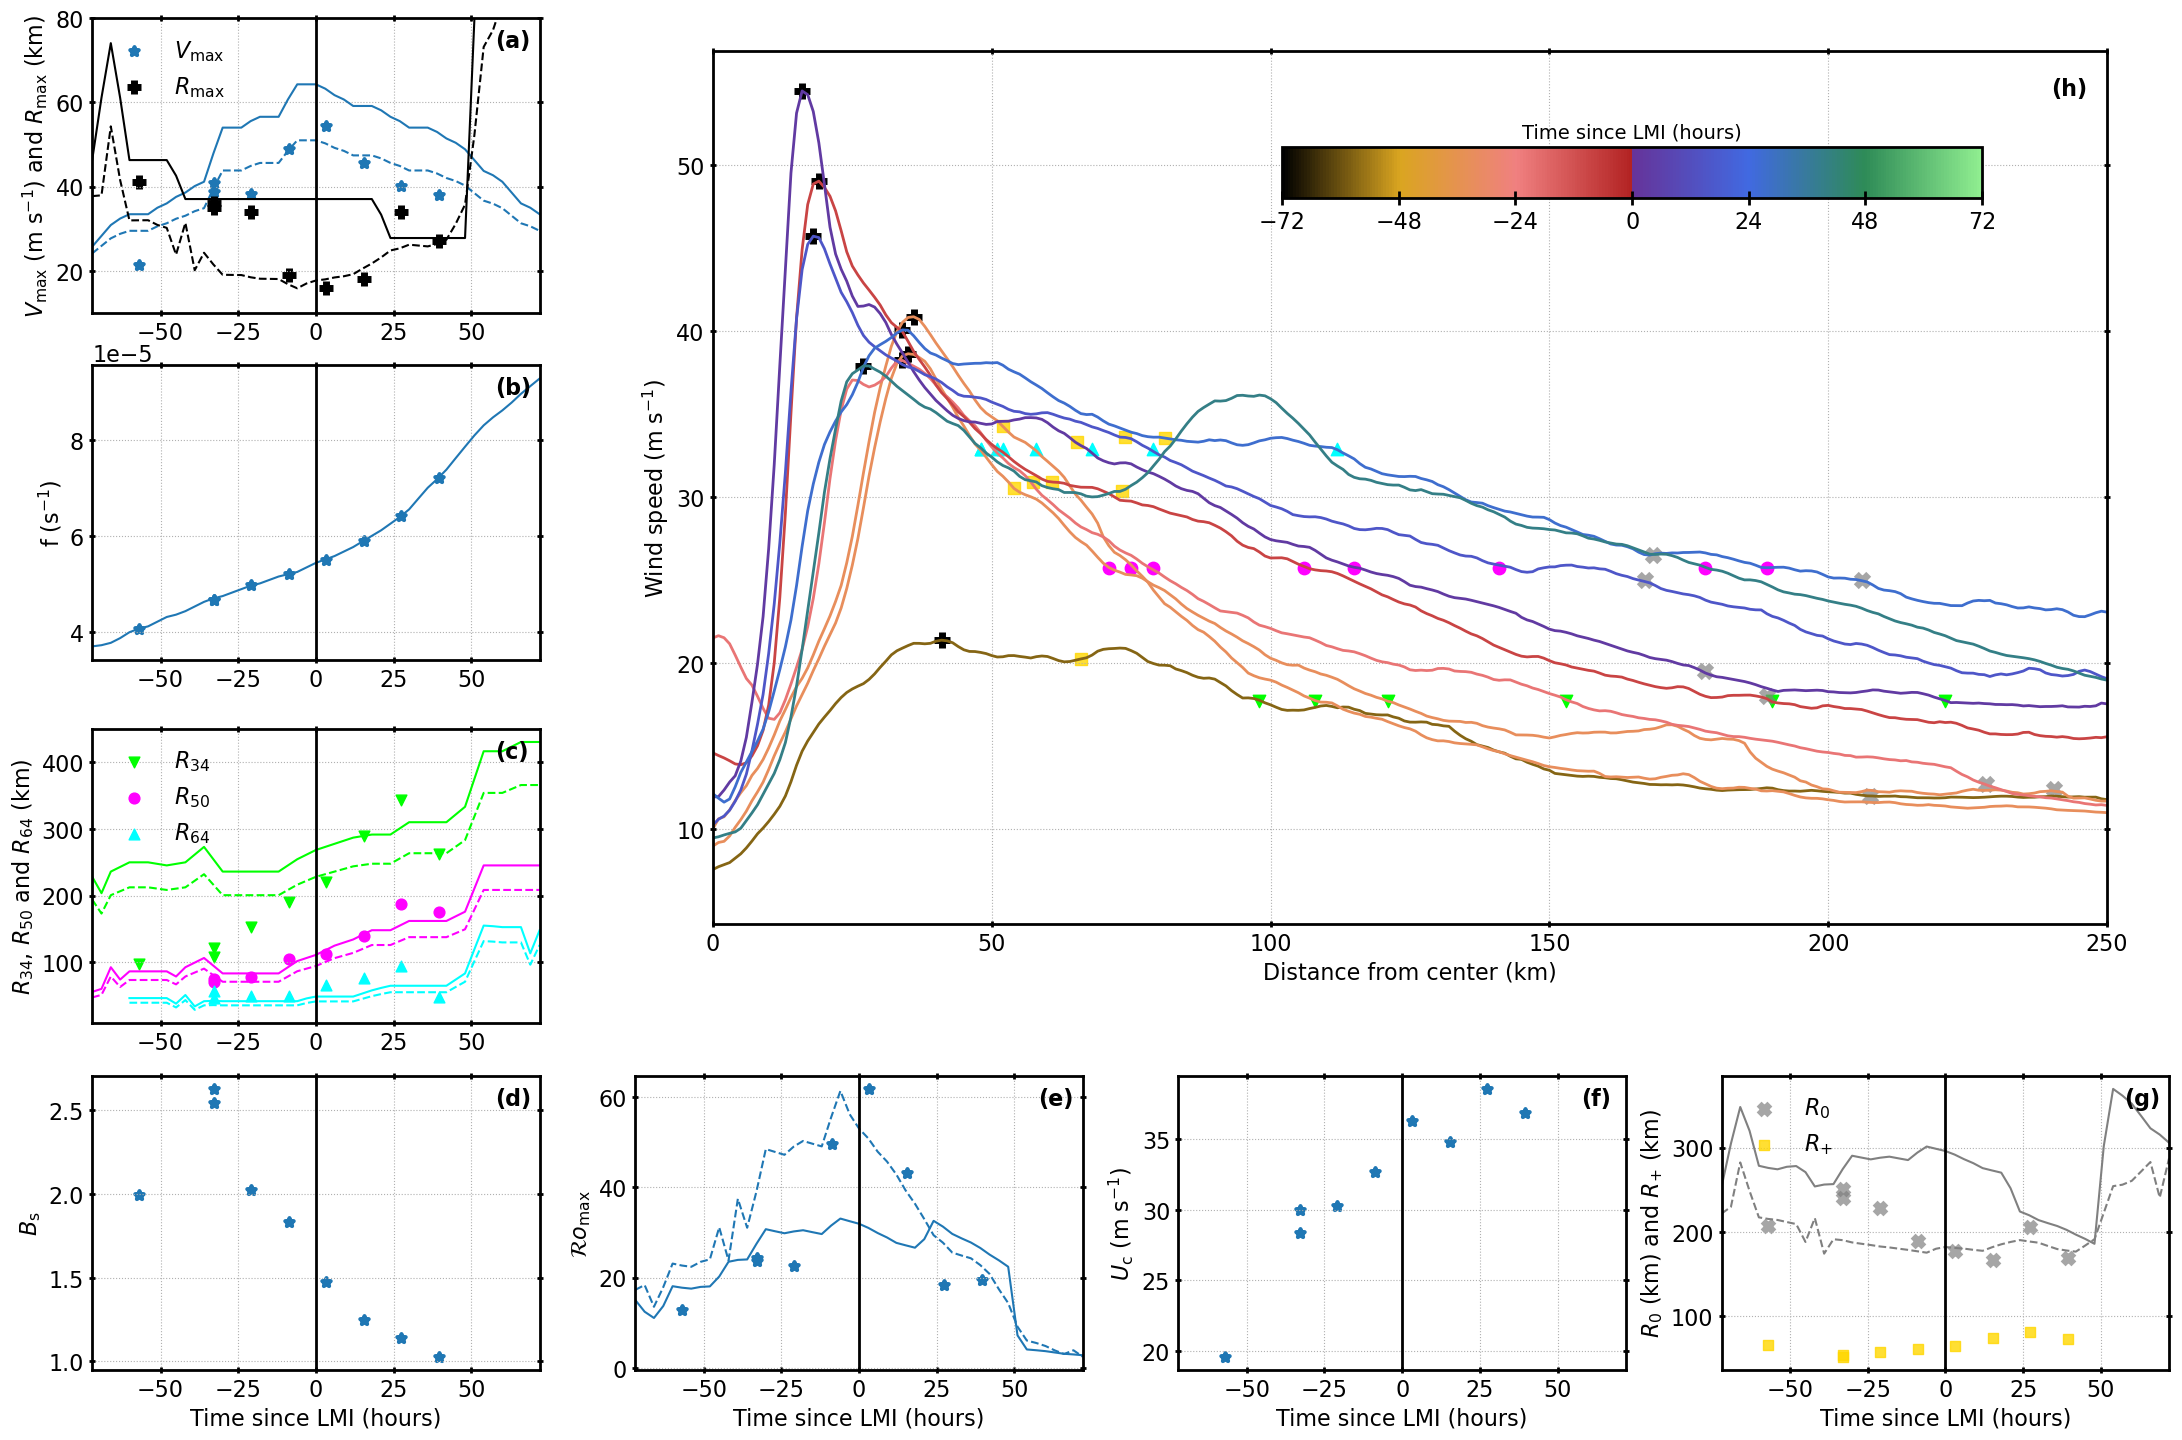

In [69]:
### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 250


fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot
    ax.plot(wsm.rad / 1000, wsm, c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2)

    # Close
    dsp.close()

# Wind radii
ax.scatter(ds.rmx  / 1000, ds.vmx,                      s=120, color='k',       marker='+',            linewidth=5)
ax.scatter(ds.r34  / 1000, np.ones_like(ds.r34) * 17.7, s=80,  color='lime',    marker='v')
ax.scatter(r50_mod / 1000, np.ones_like(ds.r50) * 25.7, s=80,  color='magenta', marker='o')
ax.scatter(r64_mod / 1000, np.ones_like(ds.r64) * 32.9, s=80,  color='cyan',    marker='^')
ax.scatter(ds.r0   / 1000, v0,                          s=80,  color='gray',    marker='x', alpha=0.7, linewidth=5)
ax.scatter(ds.rps  / 1000, vps_mod,                     s=80,  color='gold',    marker='s', alpha=0.8)

# Axes
ax.set_xlim(0, ax_lim)
ax.set_ylabel(r'Wind speed (m s$^{-1}$)')
ax.set_xlabel(r'Distance from center (km)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

################
### RMX/VMX  ###
################
ax = fig.add_subplot(gs[:18, :29])
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx,        s=40,  color='tab:blue', marker='*', linewidth=3, label=r'$V_{\text{max}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rmx / 1000, s=100, color='k',        marker='+', linewidth=5, label=r'$R_{\text{max}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_wind,         color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.vmx_reg,          color='tab:blue', linestyle='dashed')
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_rmw / 1000,   color='k')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rmx / 1000,   color='k',        linestyle='dashed')
ax.set_ylim(10, 80)

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$) and $R_{\text{max}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   FCOR   ###
################
ax = fig.add_subplot(gs[21:39, :29])
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.fcor, s=40, color='tab:blue', marker='*', linewidth=3)
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.fcr,       color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'f (s$^{-1})$')
# ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   Rxx    ###
################
ax = fig.add_subplot(gs[43:61, :29])
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600,  ds.r34 / 1000, s=60,  color='lime',    marker='v', label=r'$R_{\text{34}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600,  ds.r50 / 1000, s=60,  color='magenta', marker='o', label=r'$R_{\text{50}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600,  ds.r64 / 1000, s=60,  color='cyan',    marker='^', label=r'$R_{\text{64}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,        dsi.mean_r34 / 1000,  color='lime')
ax.plot(dsi.t_since_lmi / 3600,        dsi.mean_r50 / 1000,  color='magenta')
ax.plot(dsi.t_since_lmi / 3600,        dsi.mean_r64 / 1000,  color='cyan')
ax.plot(dsi.t_since_lmi / 3600, 0.85 * dsi.mean_r34 / 1000,  color='lime',    linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600, 0.85 * dsi.mean_r50 / 1000,  color='magenta', linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600, 0.85 * dsi.mean_r64 / 1000,  color='cyan',    linestyle='dashed',)


# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Bs    ###
################
ax = fig.add_subplot(gs[64:82, :29])
ax.text(0.9, 0.9, '(d)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.B_hol, s=40, color='tab:blue', marker='*', linewidth=3)
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,    dsi.Bs,                        color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$B_{\text{s}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  Rossby  ###
################
ax = fig.add_subplot(gs[64:82, 35:64])
ax.text(0.9, 0.9, '(e)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rsby, s=40, color='tab:blue', marker='*', linewidth=3)
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.rsb,       color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rsb,   color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Uc    ###
################
ax = fig.add_subplot(gs[64:82, 70:99])
ax.text(0.9, 0.9, '(f)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.uc, s=40, color='tab:blue', marker='*', linewidth=3)

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  R+/R0   ###
################
ax = fig.add_subplot(gs[64:82, 105:134])
ax.text(0.9, 0.9, '(g)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r0 / 1000,  s=60,  color='gray', marker='x', alpha=0.7, linewidth=5, label=r'$R_{\text{0}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rps / 1000, s=60,  color='gold', marker='s', alpha=0.8,              label=r'$R_{\text{+}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.r0 / 1000,        color='gray')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_r0 / 1000,    color='gray', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{0}}$ (km) and $R_{\text{+}}$ (km)')
ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False, loc='upper left')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# # Save
# plt.savefig(PTHS['sav_dir'] + 'intro_case.png', bbox_inches='tight')

In [15]:
# plt.scatter(ds.t_since_lmi_ibt / 3600, ds.pre_sst_rms)
# plt.grid()

### Tests

#### Comparison with universal profile

In [16]:
def holland_star(x, B, vmn=0.3):
    '''Divide Eq. 7 of the MWR 2023 paper by Vmax to understand what's happening.
    The constant is then necessarily equal to f * Rmax / (2 * Vmax).
    '''
    # c = 0.01679847129304227
    c = 0.017
    return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c

### REFERENCE GRID
xs = np.linspace(0, 20, 1000)

/tmp/ipykernel_17306/1773553959.py:7: RuntimeWarning: divide by zero encountered in divide
  return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c
/tmp/ipykernel_17306/1773553959.py:7: RuntimeWarning: invalid value encountered in multiply
  return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c


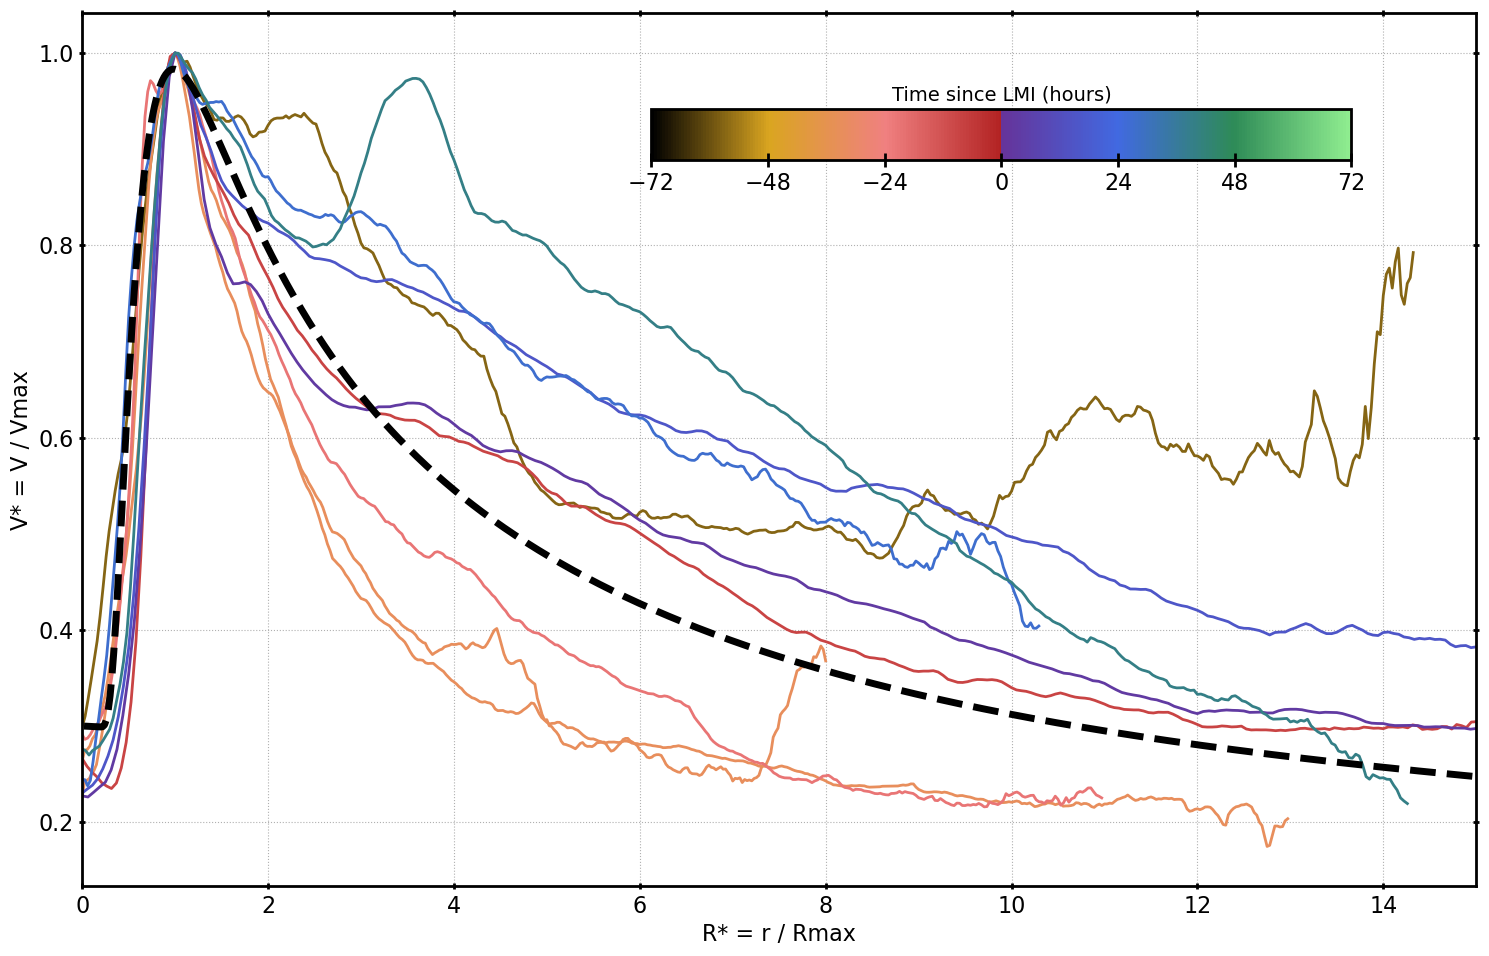

In [17]:
### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 15


fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
# ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot
    ax.plot(wsm.rad / wsm.idxmax(), wsm / wsm.max(), c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2)

    # Close
    dsp.close()
ax.plot(xs, holland_star(xs, 1.84, vmn=0.3), label='Holland', c='k', linewidth=5, linestyle='dashed')

# Axes
ax.set_xlim(0, ax_lim)
ax.set_xlabel('R* = r / Rmax')
ax.set_ylabel('V* = V / Vmax')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

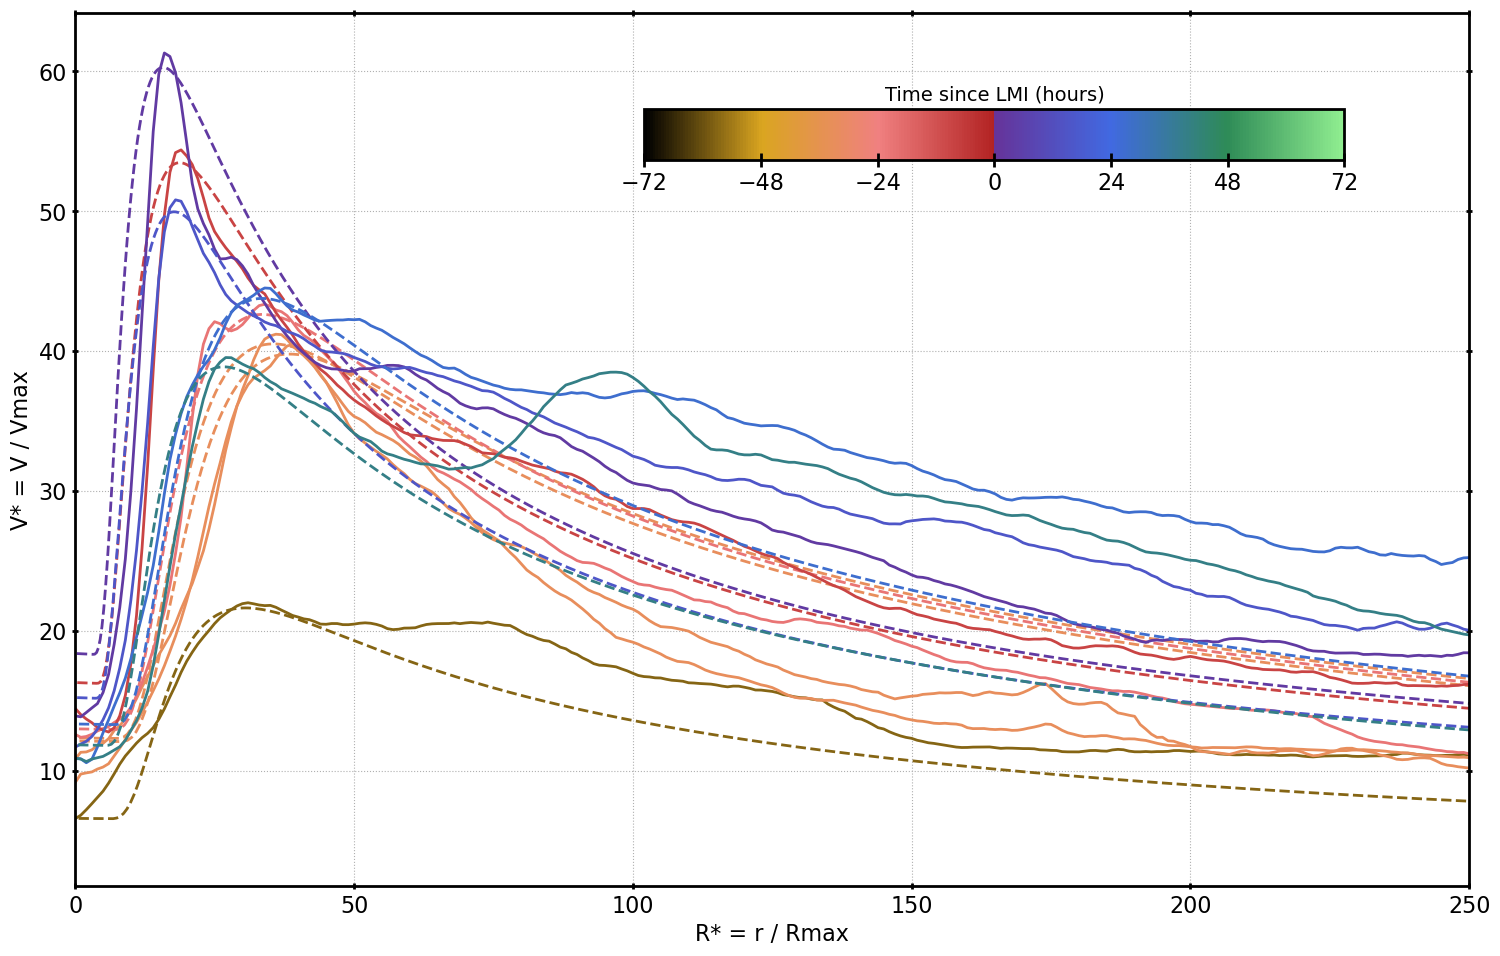

In [18]:
### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 250


fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
# ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot actual SAR
    ax.plot(wsm.rad / 1000, wsm, c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2)
    # Estimated wind profile based on the universal profile
    plt.plot(xs[1:] * float(dss.rmx) / 1000, holland_star(xs[1:], 1.84, vmn=0.3) * float(dss.vmx), c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2, linestyle='dashed')

    # Close
    dsp.close()
# ax.plot(xs, holland_star(xs, 1.84, vmn=0.3), label='Holland', c='k', linewidth=5, linestyle='dashed')

# Axes
ax.set_xlim(0, ax_lim)
ax.set_xlabel('R* = r / Rmax')
ax.set_ylabel('V* = V / Vmax')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

### Test wind radii

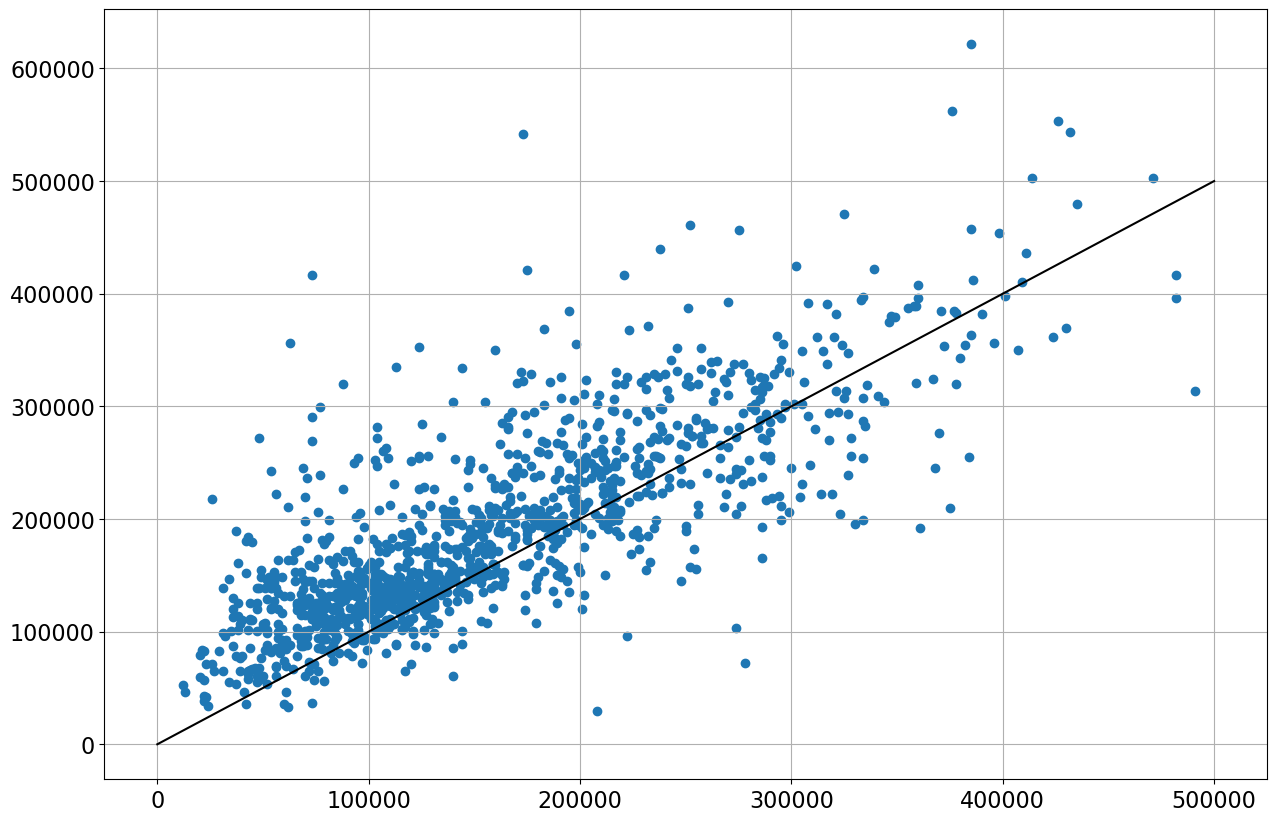

In [19]:
plt.scatter(dsg.r34, dsg.r34_ibt)
# plt.scatter(dsg.r34, 0.85 * dsg.r34_ibt)
plt.plot([0, 500000], [0, 500000], c='k')
plt.grid()

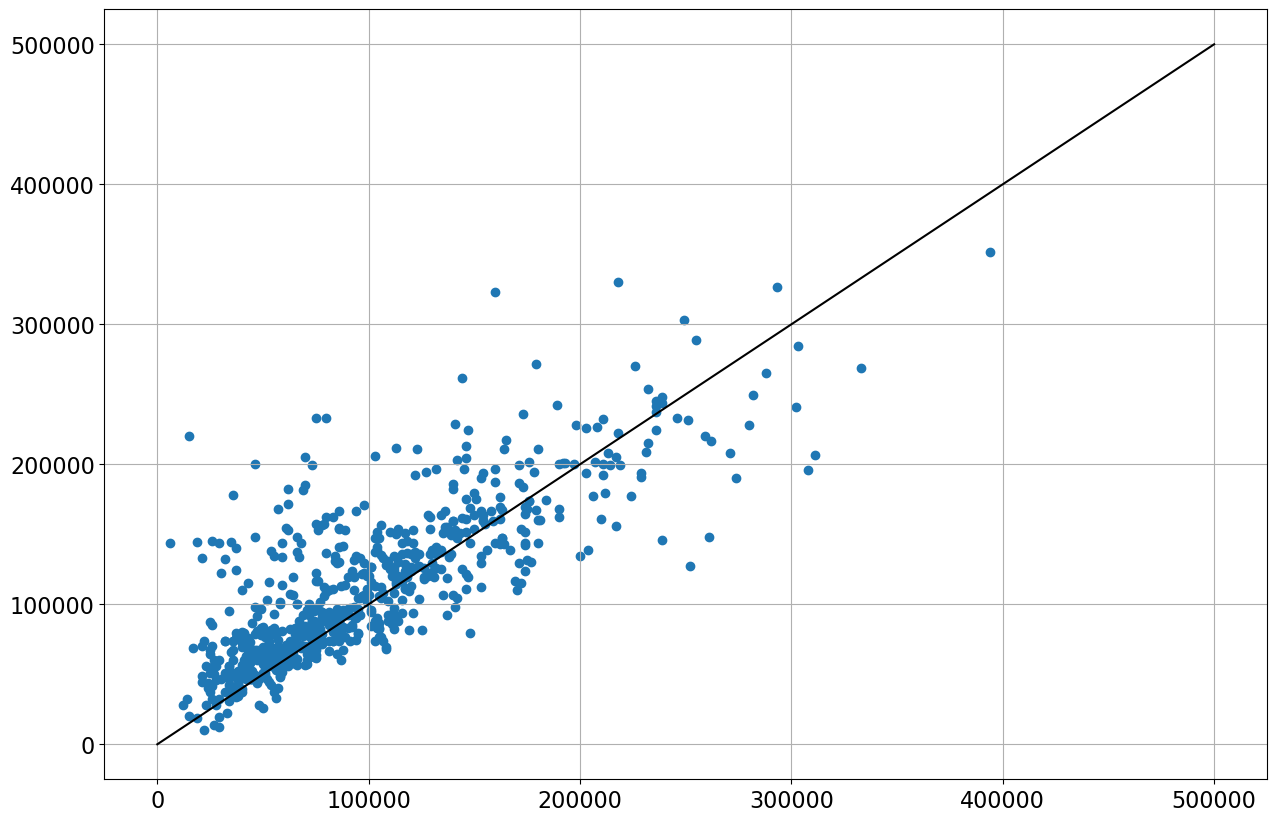

In [20]:
plt.scatter(dsg.r50, dsg.r50_ibt)
# plt.scatter(dsg.r50, 0.9 * dsg.r50_ibt)
plt.plot([0, 500000], [0, 500000], c='k')
plt.grid()

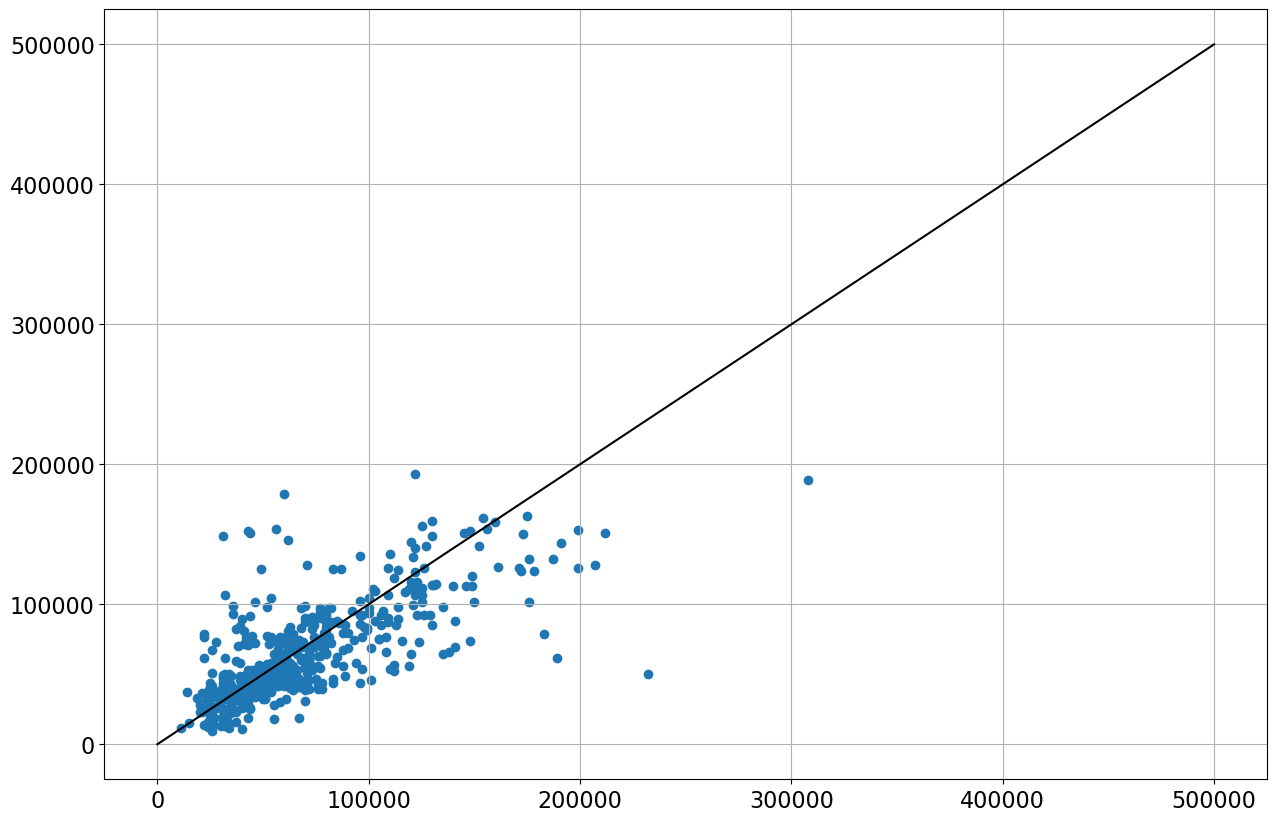

In [21]:
plt.scatter(dsg.r64, dsg.r64_ibt)
# plt.scatter(dsg.r64, 0.95 * dsg.r64_ibt)
plt.plot([0, 500000], [0, 500000], c='k')
plt.grid()

### Perhaps choose other cases

In [22]:
ids, cts = np.unique(d.id, return_counts=True)

AttributeError: 'int' object has no attribute 'id'

In [ ]:
# for atcf_id in ids[cts >= 8]:
#     print(atcf_id)
#     ds = d.where(d.id == atcf_id, drop=True)
#     plt.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx)
#     plt.axvline(0, c='k')
#     plt.grid()
#     plt.xlim(-72, 72)
#     plt.show()